# Mercarri Price Suggestion

In this project I am dealing with the data provided by [Mercarri](https://www.mercari.com/) e-commerce company, which is mainly operated in japan. The problem here is I have to predict the prices of the products which have been provided by Mercarri.

This project follows **CRISP-DM** architectecture and also satisfies **PEP-8** Convention.

## 1. Business Understanding

Generally, Right choice of pricing a product can never be static, it has to be varying based on the market demand for that,I build a model that automatically suggests the right product prices. There are various factors which can effect the price of product. Let's dive in detail this in data understanding section.

You can find the data used in this project in [Data](https://www.kaggle.com/saitosean/mercari)

### Importing Dependencies
First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of code

In [4]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from scipy.sparse import csr_matrix, hstack
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from wordcloud import WordCloud

## 2. Data Understanding

Let us understand the each attribute present in the data more carefully. We have total of 8 attributes and 6 million records in train data.


* train_id  — the id of the listing


* name   —  the title of the listing


* item_condition_id   —  the condition of the items provided by the sellers


* category_name  —  category of the listing


* brand_name  —  the name of the brand


* price  —  the price that the item was sold for. This is target variable that we will predict


* shipping  —  1 if shipping fee is paid by seller and 0 by buyer


* item_description  —  the full description of the item

## 3. Data preparation.

Let us further split the train data set in training and validation dataset. We will split the data into 80 percent training data and 20 percent testing data. Do some exploration on training data set.

### 3.1 Get the data

In [5]:
def train_val_split(train_data_path):
    """
    Split the training data into train and validation data
    :dataframe: 
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    train_dataframe = pd.read_csv(train_data_path, sep = '\t')
    index = np.random.rand(len(train_dataframe)) < 0.8
    train_data = train_dataframe[index]
    val_data = train_dataframe[~index]
    return train_data,val_data

###  3.2 Exploratory Data Analysis

In [6]:
# Get the training data after split
train_df,val_df=train_val_split('train.tsv')
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,59.0,0,"Banana republic bottoms, Candies skirt with ma..."


In [7]:
# Get the information about each attribute
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 474792 entries, 0 to 593375
Data columns (total 8 columns):
train_id             474792 non-null int64
name                 474792 non-null object
item_condition_id    474792 non-null int64
category_name        472770 non-null object
brand_name           272235 non-null object
price                474792 non-null float64
shipping             474792 non-null int64
item_description     474792 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 32.6+ MB


<b> 3.2.1 Let us Explore more on Price attribute</b>

In [8]:
train_df.price.describe()

count    474792.000000
mean         26.667583
std          38.072090
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max        2000.000000
Name: price, dtype: float64

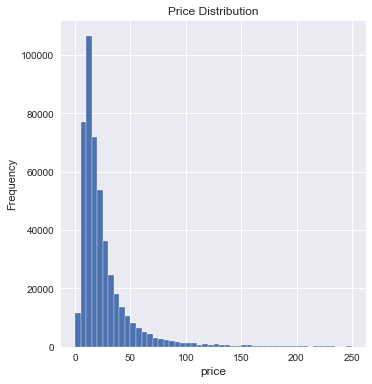

In [9]:
# Distribution of data in price attribute
plt.subplot(1, 2, 1)
(train_df['price']).plot.hist(bins=50, figsize=(12, 6), edgecolor = 'white', range = [0, 250])
plt.xlabel('price', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.savefig('price.png')
plt.show()

The price of items are right skewed , vast majority of items priced at 10-20. However, the most expensive item priced at 2009. So we make log-transformation on the price.

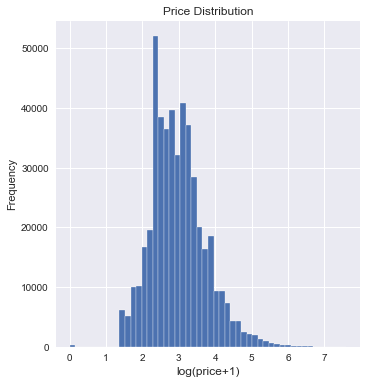

In [53]:
# Distribution of data in price attribute after log normalization
plt.subplot(1, 2, 2)
np.log(train_df['price']+1).plot.hist(bins=50, figsize=(12,6), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.title('Price Distribution', fontsize=12)
plt.show()

<b> 3.2.2 Let us Explore more on shipping attribute</b>

In [9]:
# No of items which got shipped
train_df['shipping'].value_counts() / len(train)

0    0.553659
1    0.446341
Name: shipping, dtype: float64

Over 55% of items shipping fee were paid by the buyers. How shipping related to price?

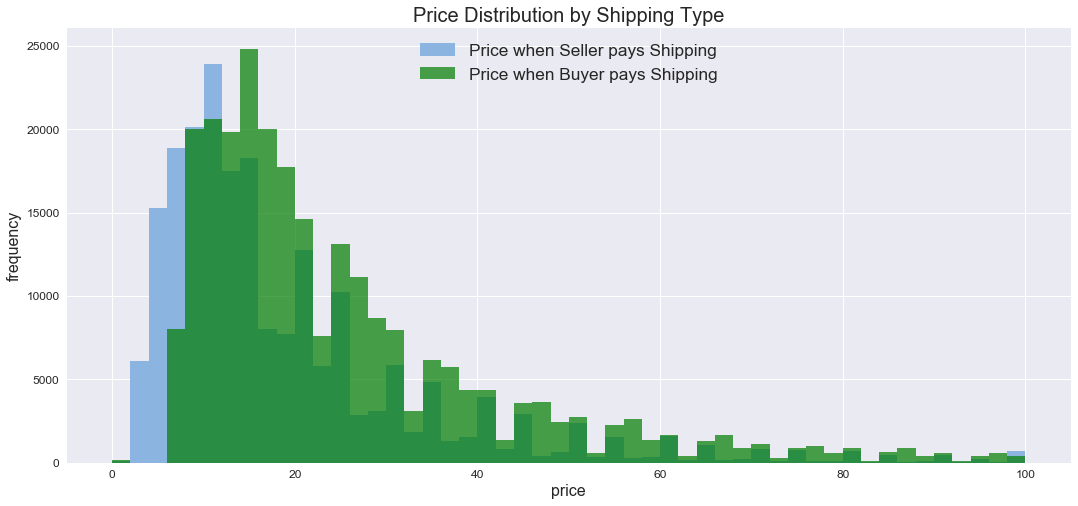

In [12]:
# Price distibution over shipping type
shipping_fee_by_buyer = train_df.loc[train_df['shipping'] == 0, 'price']
shipping_fee_by_seller = train_df.loc[train_df['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=16)
plt.ylabel('frequency', fontsize=16)
plt.title('Price Distribution by Shipping Type', fontsize=20)
plt.tick_params(labelsize=12)
plt.savefig('shipping.png')
plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.show()

In [13]:
# The average price respective to shipping
print('The average price is {}'.format(round(shipping_fee_by_seller.mean(), 2)), 'if seller pays shipping');
print('The average price is {}'.format(round(shipping_fee_by_buyer.mean(), 2)), 'if buyer pays shipping')

The average price is 22.44 if seller pays shipping
The average price is 30.08 if buyer pays shipping


We compare again after log-transformation on the price.

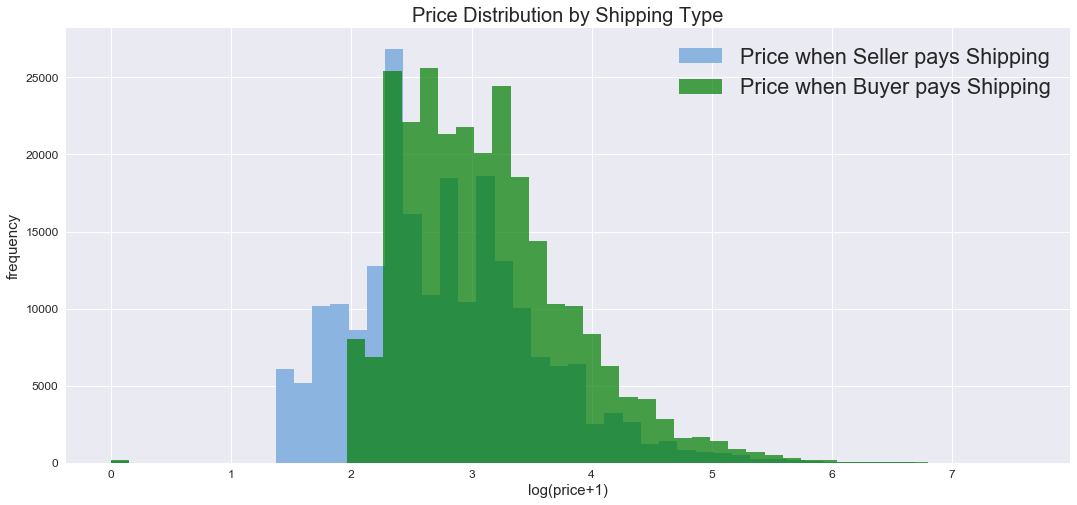

In [74]:
# Price dustribution by shipping type
fig, ax = plt.subplots(figsize=(18,8))
ax.hist(np.log(shipping_fee_by_seller+1), color='#8CB4E1', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_fee_by_buyer+1), color='#007D00', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
plt.xlabel('log(price+1)', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.title('Price Distribution by Shipping Type', fontsize=20)
plt.tick_params(labelsize=12)
plt.legend(loc='upper right', shadow=True, fontsize='x-large')
plt.savefig('shipping.png')
plt.show()

It is obvious that the average price is higher when buyer pays shipping.

<b>3.2.3 Let us explore more on category_name attribute</b>

In [13]:
print('There are', train_df['category_name'].nunique(), 'unique values in category name column')

There are 1172 unique values in category name column


Top 10 most common category names

In [28]:
train_df['category_name'].value_counts()[:10]

Women/Athletic Apparel/Pants, Tights, Leggings                 19157
Women/Tops & Blouses/T-Shirts                                  14885
Beauty/Makeup/Face                                             10957
Beauty/Makeup/Lips                                              9596
Electronics/Video Games & Consoles/Games                        8530
Beauty/Makeup/Eyes                                              8226
Electronics/Cell Phones & Accessories/Cases, Covers & Skins     7930
Women/Underwear/Bras                                            6879
Women/Tops & Blouses/Tank, Cami                                 6543
Women/Tops & Blouses/Blouse                                     6513
Name: category_name, dtype: int64

<b>3.2.4 Item condition vs. Price</b>

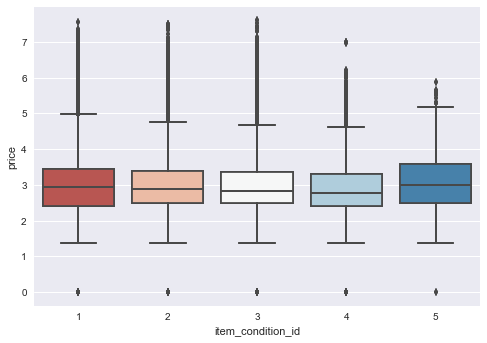

In [58]:
sns.boxplot(x = 'item_condition_id', y = np.log(train_df['price']+1), data = train_df, palette = sns.color_palette('RdBu',5))
plt.show()

There seems to be various items on the average price between each item condition id.

**Therefore, we are going to use all the features to build our model.**

### Discussion 3.2 (EDA)




**Price:**


* The price of items are right skewed , vast majority of items priced at 10-20.


* However, the most expensive item priced at 2009. So we make log-transformation on the price.


**Shipping:**
    
    
* The average price is 22.44 if seller pays shipping


* The average price is 30.08 if buyer pays shipping


It is obvious that the average price is higher when buyer pays shipping.

## 4. Categorical and Missing data handling

In [17]:
print('There are %d items that do not have a category name.' %train['category_name'].isnull().sum())

There are 2040 items that do not have a category name.


In [18]:
print('There are %d items that do not have a brand name.' %train['brand_name'].isnull().sum())

There are 202703 items that do not have a brand name.


In [19]:
print('There are %d items that do not have a description.' %train['item_description'].isnull().sum())

There are 1 items that do not have a description.


In [20]:
def handle_missing_inplace(dataset): 
    """
    Handles the missing values by adding a word missing
    :dataset: 
    :we are merging the optput using merge function later instead of returning from here
    """
    dataset['category_name'].fillna(value='missing', inplace=True) 
    dataset['brand_name'].fillna(value='missing', inplace=True) 
    dataset['item_description'].replace('No description yet,''missing', inplace=True) 
    dataset['item_description'].fillna(value='missing', inplace=True)

In [21]:
def cutting(dataset):
    """
    Slices the dataset by using model parameters
    :dataframe: 
    :we are merging the optput using merge function later instead of returning from here
    """
    pop_brand = dataset['brand_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_BRANDS]
    dataset.loc[~dataset['brand_name'].isin(pop_brand), 'brand_name'] = 'missing'
    pop_category = dataset['category_name'].value_counts().loc[lambda x: x.index != 'missing'].index[:NUM_CATEGORIES]

In [22]:
def to_categorical(dataset):
    """
    Converting the following attributes to category so that we can derive dummies
    from this later in this project
    :dataframe: 
    :we are merging the optput using merge function later instead of returning from here
    """
    dataset['category_name'] = dataset['category_name'].astype('category')
    dataset['brand_name'] = dataset['brand_name'].astype('category')
    dataset['item_condition_id'] = dataset['item_condition_id'].astype('category')

In [25]:
# Get the data from split data function
val_df_new = val_df.drop('price', axis=1)
y_val = np.log1p(val_df["price"])

In [29]:
def merge_dataframe(train_df):
    """
    After modifying val dataset and slicing using model constants we are merging the dataframe
    :dataframe 
    :merged dataframe
    """
    train_df = train_df[train_df.price != 0].reset_index(drop=True)
    nrow_train = train_df.shape[0]
    y = np.log1p(train_df["price"])
    merge: pd.DataFrame = pd.concat([train_df, val_df_new])
    handle_missing_inplace(merge)
    cutting(merge)
    to_categorical(merge)
    return merge

### Discussion 4.1 (Data Handling)

Before performing modelling we have to identify the following


* Are there any attibutes which contain categorical(Non numerical) data. Because no model can directly work on non numerical data. 


* Are there any columns which contain missing data. (There can be many ways for dealing this problem.)


Firstly, for handling categorical data, we have chosen state of the art encoders to convert them to numerical values. As the price column is continuous no special handling for that attribute.


Secondly, we have dealt missing data handling differently for price attribute among all other attributes
  
  * As price is the attribute which we want to predict, We cannot impute the values using any descriptive statistics, According to the problem domain knowledge I thought it is better to drop rows which contain null or zero values in price column.
  
  
  * For other columns we filled the missing values by the average value of that particular column.
  

Doing this will be helpful in feature selection

## 5. Feature Selection

In [19]:
NUM_BRANDS = 4000
NUM_CATEGORIES = 1000
NAME_MIN_DF = 10
MAX_FEATURES_ITEM_DESCRIPTION = 50000

In [30]:
merge=merge_dataframe(train_df)
cv = CountVectorizer(min_df=NAME_MIN_DF)
X_name = cv.fit_transform(merge['name'])

In [31]:
cv = CountVectorizer()
X_category = cv.fit_transform(merge['category_name'])

TFIDF Vectorize item_description column.

In [32]:
tv = TfidfVectorizer(max_features=MAX_FEATURES_ITEM_DESCRIPTION, ngram_range=(1, 3), stop_words='english')
X_description = tv.fit_transform(merge['item_description'])

Label binarize brand_name column.

In [33]:
lb = LabelBinarizer(sparse_output=True)
X_brand = lb.fit_transform(merge['brand_name'])

Create dummy variables for item_condition_id and shipping columns.

In [34]:
X_dummies = csr_matrix(pd.get_dummies(merge[['item_condition_id', 'shipping']], sparse=True).values)

Create sparse merge.

In [35]:
sparse_merge = hstack((X_dummies, X_description, X_brand, X_category, X_name)).tocsr()

In [36]:
sparse_merge.shape

(593123, 66111)

Remove features with document frequency <=1.

In [37]:
mask = np.array(np.clip(sparse_merge.getnnz(axis=0) - 1, 0, 1), dtype=bool)
sparse_merge = sparse_merge[:, mask]

In [38]:
sparse_merge.shape

(593123, 64917)

Separate train and test data from sparse merge.

In [40]:
X = sparse_merge[:train_df.shape[0]]
X_test = sparse_merge[train_df.shape[0]:]

In [42]:
train_X = lgb.Dataset(X)

### Discussion 5.1 (Feature Selection)


* This is the most important one to do before performing any modelling.


* Selecting the features (columns) for modelling. There might be many useless features which are not required for modelling. Here, We have got many columns after performing categorical encoding and TF-IDF.


* We removed the columns whose relevancy was minimum using TF-IDF, This technique will penalize the words like **the, and, is, a ...** 


* Finally we got the columns which are relevant for modelling.

## 6. Hyper parameters

In [43]:
params = {
        'learning_rate': 0.75,
        'application': 'regression',
        'max_depth': 3,
        'num_leaves': 100,
        'verbosity': -1,
        'metric': 'RMSE',
    }

### 6.1 Discussion (Hyper Parameters)

* Learning rate, max_depth and num_leaves are the important hyper parameters to play around with.


* For num_leaves I set value as 100 because we want to avoid overfitting

## 7. Training

In [44]:
gbm = lgb.train(params, train_set=train_X, num_boost_round=3000, verbose_eval=100)

### 7.1 Discussion (Training)

* We used a tree based model (GBM), which can capture non linear pattern in the data if present. 


* This model is powerful enough for most of the problems. 


* One main advantage of using this is we can also rank the features which dominated during prediction in serial order. An excellent model for interpretation.

## 8. Evaluation

In [45]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [42]:
from sklearn.metrics import mean_squared_error
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

The rmse of prediction is: 0.4797012687042281


### 8.1 Discussion (Evaluation)

* Here we got pretty good results when we predicted on the test data (Production data). 


* The error was very minimal i.e 0.479, which indicates our model is performing better.

## Business Insights
    
* Apart from modelling we can also help comanies by delivering some meaningful insights, which will help them to improve their business.


* Our methodology and process are designed in such a way that it can even answer very good business queries.


* We help business in increasing the ROI for the company by proving some useful insights.

## 9.1 Business Question 1

### Can you tell me which feature is most important for determining the price of product?

We want to prioritize that feature for improving our business.

We have chosen a model which helps in interpretation. We can get the feature which is most dominating for predicting the price.

In [47]:
gain = gbm.feature_importance('gain')
feature_dataframe = pd.DataFrame({'feature':gbm.feature_name(), 'split':gbm.feature_importance('split'), 'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)

### Item Condition is the most dominating factor

Condition of item is playing a crucial role in and it is capturing 8 percent of variance of the dependent variable that also indicates that it is root node of GBM.

In [102]:
sorted_feature=df.sort(['gain'], descending=[0])
sorted_feature.head()

,feature,gain,split
0,item_condition,8.23,37983
1,T_5121,4.27,18992
2,T_8576,3.12,15193
3,T_6321,2.06,9495
4,shipping,1.48,7121


### Discussion 9.1.1: 

* Above table consists sorted features with gain percentages and split. As you can see the top feature is item_condition. which means that attribute dominated most while predicting the price and next dominating attributes are terms in item_description attribute.


* You can also see shipping cost also playing a dominant role for predicting the price.


* Gain column indicates the level of importance in percentage of that attribute during prediction. 


* The information gain is based on the decrease in entropy(measure of randomness) after a dataset is split on an attribute. 

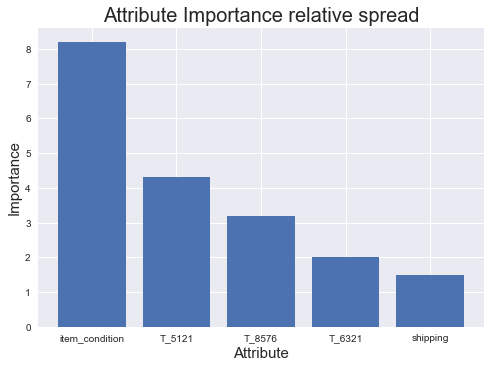

In [57]:
# Attribute importance
x=sorted_feature['feature'].values[:5]
y=sorted_feature['gain'].values[:5]
plt.bar(x,y) 
plt.xlabel('Attribute',fontsize=15)
plt.ylabel('Importance in Percentages',fontsize=15)
plt.title('Attribute Importance relative spread',fontsize=20)
plt.savefig('Attribute_Importance.png')
plt.show()

As we don't know what are the 3 values, we can get the terms which dominated the most in item description.

### Let us map the 3 attribute to words for getting which words in item description dominated the price prediction.

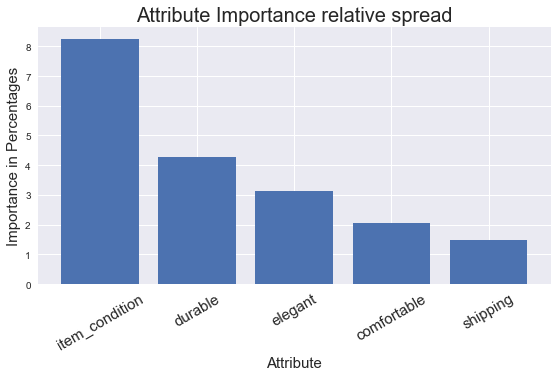

In [106]:
# Plot the modified bar diagram
terms=[5121,8576,6321]
modified_x=[]
modified_x.append(x[0])
modified_x.extend([term_vocab_map[term] for term in terms])
modified_x.append(x[4])
y=sorted_feature['gain'].values[:5]
plt.bar(modified_x,y) 
plt.xticks(modified_x, fontsize=15, rotation=30)
plt.xlabel('Attribute',fontsize=15)
plt.ylabel('Importance in Percentages',fontsize=15)
plt.title('Attribute Importance relative spread',fontsize=20)
plt.tight_layout()
plt.savefig('Attribute_Importance.png')
plt.show()

### Discussion 9.1.2

* As you can see in the bar diagram, finally we got the attributes which are most important for prediction.


* The terms **durable** and **comfortable** make sense and it is a really good insight, we can tell to mercarri that these are the factors that they have to concentrate for increasing ROI.


**Insight:** If company can take care of product condition, it will be getting better ROI.


## 9.2 Business Question 2

### Is Item description factor is needed for predicting the price?

If needed what are the most dominating words which appealed customers to purchase?

Yes Item description is very much needed you can see that as second dominating feature with 6 percentage of information gain what are the words which dominating the most, let us see.

In [134]:
# Creating tf-idf vectorizer and Apply 50 percent weightage for most weightage words
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vec = TfidfVectorizer(tokenizer=re_tok.sub(r' ', s).split(),max_df=0.5,ngram_range=(1, 3))
tf_vec=vec.fit_transform(merge['item_description'])

In [135]:
# Sort the words according to weights which state the relevancy of words
indices = np.argsort(vec.idf_)[::-1]
features = vec.get_feature_names()
top_n = len(features)
top_features = [features[i] for i in indices[1:40]]

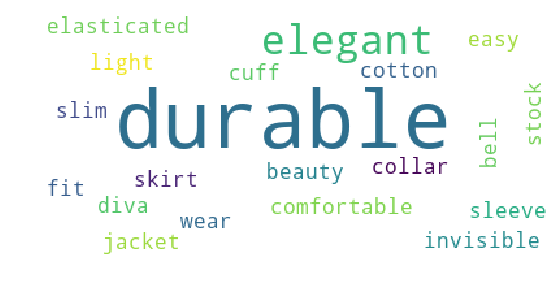

In [76]:
# Create a word cloud
dict_word={}
for k,v in zip(top_features,weights):
    dict_word[k] = v
wordcloud = WordCloud(background_color='white',width=400,height=200, max_words=20,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(dict_word)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("item_desc.png", dpi=1000)
plt.tight_layout()
plt.show()

### Discussion 9.2.1

* The above plot is called as word cloud. Here the **larger the word is, the greater influence they were found to have.**


* The size of the word is determined by the importance they carry in prediction. 


* As you can see the words like comfortable, elegant and durable came as most dominating factors because most people tend to buy the products which are essentially durable.


**Insight:** I feel it is a really good insight because we can tell to mercarri that these are the terms which will play crucial role in item description to improve the purchase intent of the customers.

## 9.3 Business question 3

### What are the brands which have good amount of quality items and also in excellent condition.

So that we can increase ROI by maximizing those brand products.

Yes, we can get the brand which attribute most to quality by doing some correspondence analysis.

In [230]:
# Get the brands grouped by all levels of item condition
grouped_df=train_df.groupby('brand_name',as_index=False)
agg_df=grouped_df.aggregate('mean')
# Get the brands which are well conditioned
well_conditioned=agg_df.loc[agg_df['item_condition_id']==3.0]['brand_name'].dropna()
# Get the brands which are average conditioned
average_conditioned=agg_df.loc[(agg_df['item_condition_id']>2.0)&(agg_df['item_condition_id']<3.0)]['brand_name'].dropna()
# Get the brands which are not conditioned
not_conditioned=agg_df.loc[(agg_df['item_condition_id']<2.0)&(agg_df['item_condition_id']>1.0)]['brand_name'].dropna()

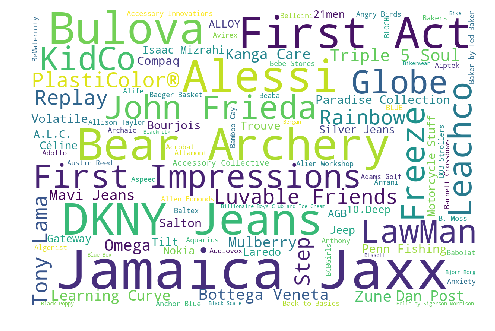

In [224]:
# Brands word cloud with respect to item condition as weights.
brand_dict={}
for brand,cond_id in agg_df[['brand_name','item_condition_id']].values:
    brand_dict[brand]=cond_id
wordcloud = WordCloud(background_color='white',width=1200,height=800, max_words=100,relative_scaling=1,normalize_plurals=False).generate_from_frequencies(brand_dict)
plt.imshow(wordcloud)
plt.axis("off")
plt.savefig("brand.png", dpi=1000)
plt.show()

### Discussion 9.3.1

* The word cloud look obvious because top brands tend to have items with excellent condition. 


* The insight we got from here is bit obvious. When we keep items of top brands there are of higher quality and customers tend to buy that and business can make maximum ROI by increasing the price of products as purchase intent is higher for those brands.


* As you can see ** Bear Archery** and **DKNY Jeans** are the top most brands and have items in excellent condition.


**Insight:** 

* Business can maximize ROI by increasing the price of products as **purchase intent** is higher for those brands.


In [235]:
# the distibution percentage of well_conditioned
full_conditioned_ratio=len(well_conditioned)*100/len(agg_df)

In [236]:
# the distibution percentage of average
average_conditioned_ratio=len(average_conditioned)*100/len(agg_df)

In [238]:
# the distibution percentage of not well
not_conditioned_ratio=len(not_conditioned)*100/len(agg_df)
nan_ratio=100-(not_conditioned_ratio+average_conditioned_ratio+full_conditioned_ratio)

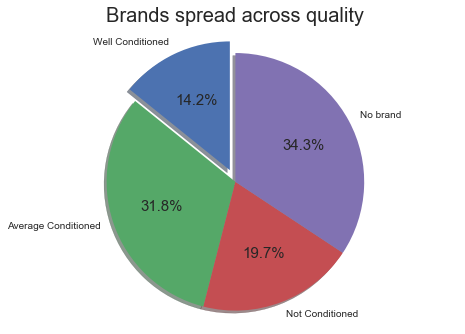

In [91]:
labels = ['Well Conditioned', 'Average Conditioned', 'Not Conditioned', 'No brand']
sizes=[full_conditioned_ratio, average_conditioned_ratio, not_conditioned_ratio, nan_ratio]
explode = (0.1, 0, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title('Brands spread across quality',fontsize=20)
plt.savefig('Percentage_brand.png')
plt.show()

### Discussion 9.3.2

* Here I have classified the brands into 3 categories. Well conditioned are the brands where all the items condition is maximum.


* Average conditioned brands are the ones which have items whose condition is between Well and Bad.


* Bad conditioned brands are the ones which have all the items which are in poor condition.


* As we can see there are only 14.3 percentage out of ~870 brands contain items which are in good condition. 


**Insight:** 

* Mercarri has to take immediate action in this and should increase the brands which contain items in excellent condition for increasing the **ROI**.

## 10. Future Enhancements

* We can make this predictions much more dynamic by considering the time factor, At what time or season the demand of product is more and some more.


* We can also bring some more seasonality aspects for effective pricing.

## 11. References

* https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
* https://pythonspot.com
* https://pandas.pydata.org/

